# **Indian Historical Monuments classification**

In [ ]:
# import dependencies
import numpy as np
import cv2
import os
import seaborn
import matplotlib.pyplot as plt
import pathlib
import glob
import imghdr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# get some hardware information
!nvidia-smi

Wed Jul 31 15:59:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu,True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
data_dir = "/content/classifier/data"

In [ ]:
os.listdir(data_dir)

['Red Fort',
 'Char Minar',
 'Golden Temple',
 'Victoria Memorial',
 'Hawa Mahal',
 'India Gate',
 'Gateway of India',
 'Lotus Temple',
 'Jantar Mantar',
 'Qutub Minar',
 'Taj Mahal',
 'Humayuns Tomb']

# **Import data, clean and explore**

In [ ]:
# get rid of all the images with weird image extensions

img_extns = ['jpg','jpeg','png','bmp'] # acceptable image extensions

for fol in os.listdir(data_dir):
    for image_path in os.listdir(os.path.join(data_dir,fol)):
        image = os.path.join(data_dir,fol,image_path) # iterate through each image in the dataset
        img = cv2.imread(image) # read the image as a numpy array
        tip = imghdr.what(image) # check image extension
        if tip not in img_extns:
            os.remove(image) # remove the image if it does not have our desired image extension
            print("Removed image with extension ->",tip)

Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> webp
Removed image with extension -> webp
Removed image with extension -> webp
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> webp
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> webp
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> webp
Removed image with extension -> None
Removed image with extension -> webp
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> None
Removed image with extension -> webp
Removed image with extension -> None
Removed image with extension -> webp
R

In [ ]:
# load the data using tensorflow.images object

data = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=32,
    image_size=(256,256)
)

Found 1575 files belonging to 12 classes.


In [ ]:
class_names = data.class_names
class_names

['Char Minar',
 'Gateway of India',
 'Golden Temple',
 'Hawa Mahal',
 'Humayuns Tomb',
 'India Gate',
 'Jantar Mantar',
 'Lotus Temple',
 'Qutub Minar',
 'Red Fort',
 'Taj Mahal',
 'Victoria Memorial']

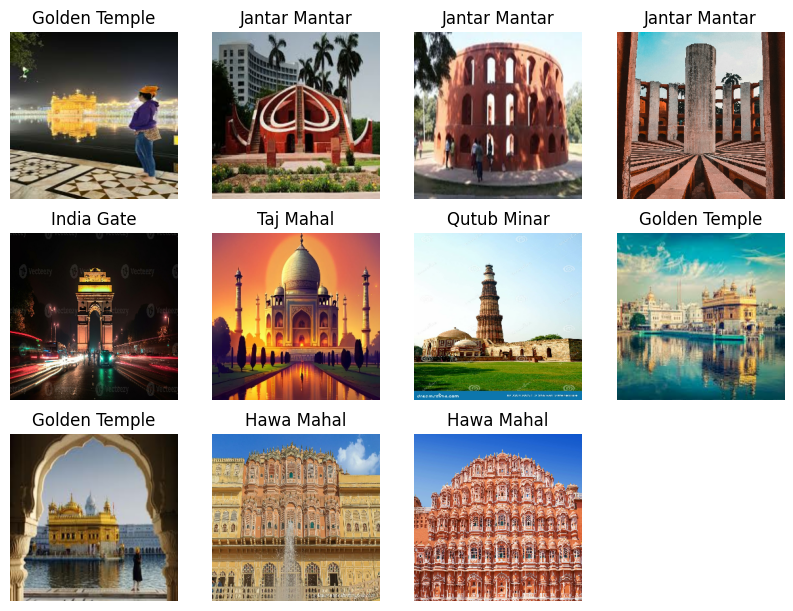

In [ ]:
# take a look at the dataset images

plt.figure(figsize=(10,10))
for images, labels in data.take(1):
    for i in range(len(class_names)-1):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8")) # get the images
        plt.title(class_names[labels[i]]) # get the labels corresponding to the images, use it to get the names
        plt.axis("off")

In [ ]:
# data will return images and its corresponding labels in batches of 32

for image_batch, label_batch in data:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 256, 256, 3)
(32,)


# **Data split and rescaling**

In [ ]:
# data rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255.0)

data = data.map(lambda x,y: (normalization_layer(x),y))
img_batch,label_batch = next(iter(data))
first_image = img_batch[0]
# notice pixel values
print(np.min(first_image),np.max(first_image))

0.0 1.0


In [ ]:
# split the dataset into train, test and validation

train_size = int(0.8*len(data)) # train -> 80%
val_size = int(0.1*len(data)) # validation -> 10%
test_size = int(0.1*len(data)) # test -> 10%

# divide the dataset
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size).skip(test_size)

# **Model Building and training**

In [ ]:
# make callbacks folder
logs = "/content/classifier/logs"
if not os.path.exists(logs):
    os.mkdir(logs)

tensorboard_callbacks = keras.callbacks.TensorBoard(log_dir=logs)

In [ ]:
num_classes = len(class_names)
# build the model
model = keras.Sequential()

# cnn layers
model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(256,256,3)))
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))

# fully connected dense layers
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [ ]:
hist = model.fit(train,epochs=10,validation_data=val,callbacks=tensorboard_callbacks,batch_size=32)

Epoch 1/10
40/40 [==============================] - 51s 1s/step - loss: 3.6138 - accuracy: 0.1672 - val_loss: 2.4741 - val_accuracy: 0.1481
Epoch 2/10
40/40 [==============================] - 50s 1s/step - loss: 1.9799 - accuracy: 0.3555 - val_loss: 2.5716 - val_accuracy: 0.0741
Epoch 3/10
40/40 [==============================] - 67s 2s/step - loss: 1.0559 - accuracy: 0.6812 - val_loss: 2.5051 - val_accuracy: 0.1852
Epoch 4/10
40/40 [==============================] - 49s 1s/step - loss: 0.3641 - accuracy: 0.9016 - val_loss: 2.1494 - val_accuracy: 0.1407
Epoch 5/10
40/40 [==============================] - 48s 1s/step - loss: 0.1468 - accuracy: 0.9633 - val_loss: 2.4013 - val_accuracy: 0.0963
Epoch 6/10
40/40 [==============================] - 47s 1s/step - loss: 0.1103 - accuracy: 0.9734 - val_loss: 2.4236 - val_accuracy: 0.0593
Epoch 7/10
40/40 [==============================] - 49s 1s/step - loss: 0.0669 - accuracy: 0.9867 - val_loss: 1.4657 - val_accuracy: 0.3852
Epoch 8/10
40/40 [==

# **Evaluation and plot performance**

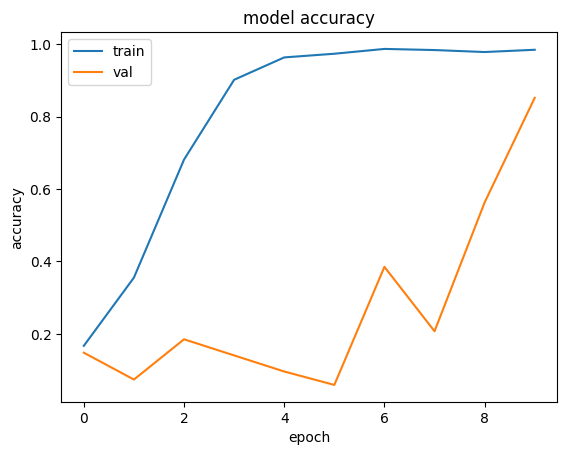

In [ ]:
# plot train acc and validation acc
fig = plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

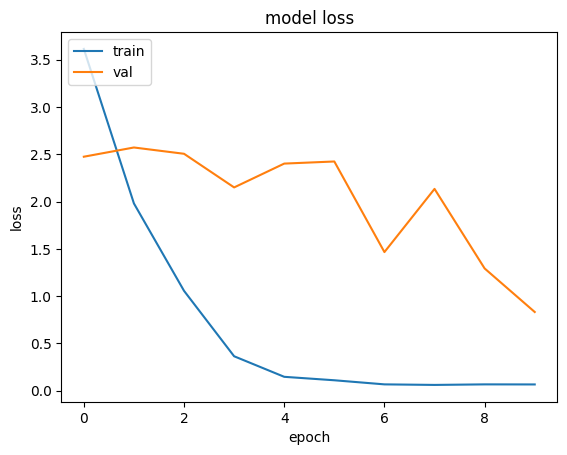

In [ ]:
# plot training loss and validation loss
fig = plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
# evaluate test loss and accuracy
met = model.evaluate(test)
print("model loss: ",met[0])
print("model accuracy: ",round(met[1]*100),"%")

5/5 [==============================] - 25s 163ms/step - loss: 0.7499 - accuracy: 0.8938
model loss:  0.7499240636825562
model accuracy:  89 %


# **Using Xception**

In [ ]:
# the custom model is having close to 88% accuracy so we will use a pretrained model to enhance accuracy as well as loss
clf_base = keras.applications.Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(256,256,3)
)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
clf_base.trainable = False

In [ ]:
model_clf = keras.Sequential([
    clf_base,

    #fully connected dense layers
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(num_classes,activation='softmax')
])


In [ ]:
model_clf.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model_clf.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_8 (Flatten)         (None, 131072)            0         
                                                                 
 batch_normalization_10 (Ba  (None, 131072)            524288    
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 256)               33554688  
                                                                 
 dense_17 (Dense)            (None, 12)                3084      
                                                                 
Total params: 54943540 (209.59 MB)
Trainable params: 33819916 (129.01 MB)
Non-trainable params: 21123624 (80.58 MB)
____

In [ ]:
logs_clf = "/content/classifier/logs_clf"
if not os.path.exists(logs_clf):
    os.mkdir(logs_clf)
tensorboard_callbacks_clf = keras.callbacks.TensorBoard(log_dir=logs_clf)

In [ ]:
history = model_clf.fit(train,epochs=10,validation_data=val,callbacks=[tensorboard_callbacks_clf])

Epoch 1/10
40/40 [==============================] - 70s 1s/step - loss: 17.5868 - accuracy: 0.7047 - val_loss: 4.1895 - val_accuracy: 0.8963
Epoch 2/10
40/40 [==============================] - 46s 1s/step - loss: 5.5487 - accuracy: 0.9289 - val_loss: 2.9273 - val_accuracy: 0.9037
Epoch 3/10
40/40 [==============================] - 45s 1s/step - loss: 3.1219 - accuracy: 0.9531 - val_loss: 4.4388 - val_accuracy: 0.8815
Epoch 4/10
40/40 [==============================] - 46s 1s/step - loss: 2.1377 - accuracy: 0.9703 - val_loss: 3.7768 - val_accuracy: 0.9185
Epoch 5/10
40/40 [==============================] - 45s 1s/step - loss: 2.4426 - accuracy: 0.9672 - val_loss: 4.0285 - val_accuracy: 0.8889
Epoch 6/10
40/40 [==============================] - 47s 1s/step - loss: 1.6329 - accuracy: 0.9711 - val_loss: 1.3258 - val_accuracy: 0.9704
Epoch 7/10
40/40 [==============================] - 46s 1s/step - loss: 1.4954 - accuracy: 0.9680 - val_loss: 2.9639 - val_accuracy: 0.9481
Epoch 8/10
40/40 [=

# **Evaluation and plot performance of Xception model**

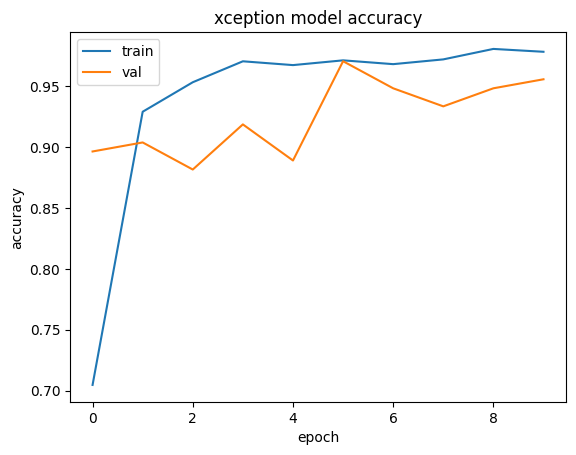

In [ ]:
# plot train acc and validation acc
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('xception model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

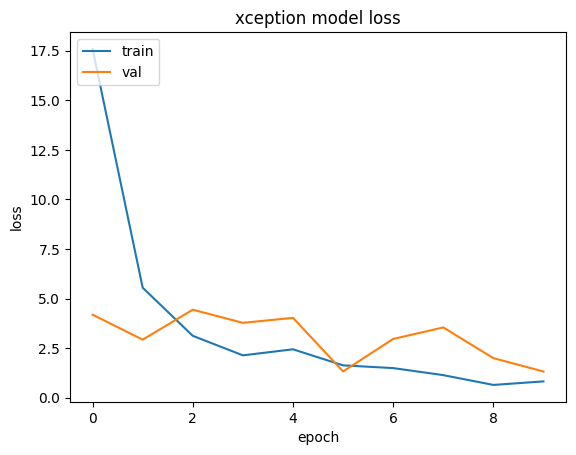

In [ ]:
# plot training loss and validation loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('xception model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
# plot model metrics
metric = model_clf.evaluate(test)
print("Xception model loss: ",metric[0])
print("Xception model accuracy: ",round(metric[1]*100),"%")

5/5 [==============================] - 21s 175ms/step - loss: 0.5625 - accuracy: 0.9688
Xception model loss:  0.5624531507492065
Xception model accuracy:  97 %


# **Test and save the model**

In [ ]:
def predict_image(image_path,model):
    '''
    Input -> image path and model
    Output -> predicted class of the image and the image itself
    '''
    img = cv2.imread(image_path)
    reimg = tf.image.resize(img,(256,256))
    yhat = model.predict(np.expand_dims(reimg/255,0))
    class_names[np.argmax(yhat)]
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
    plt.title(class_names[np.argmax(yhat)])
    plt.axis("off")

1/1 [==============================] - 0s 69ms/step


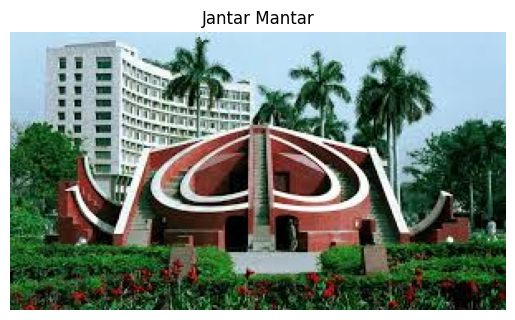

In [ ]:
predict_image("/content/testimg.jpg",model_clf)

1/1 [==============================] - 0s 53ms/step


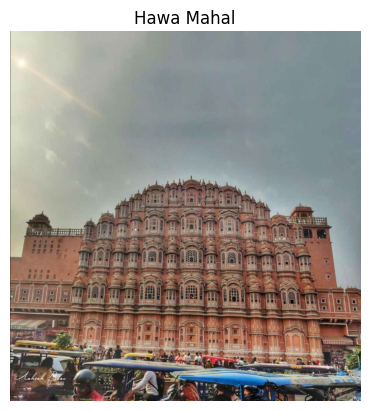

In [ ]:
predict_image("/content/testimg2.jpg",model_clf)

1/1 [==============================] - 0s 23ms/step


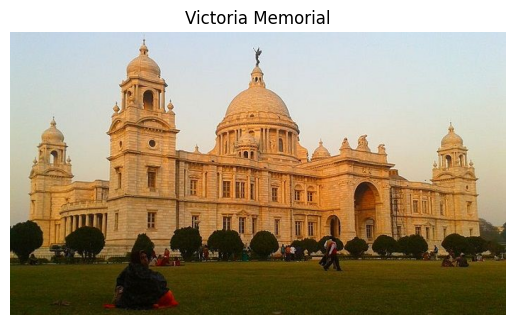

In [ ]:
predict_image("/content/testimg3.jpg",model_clf)

1/1 [==============================] - 0s 22ms/step


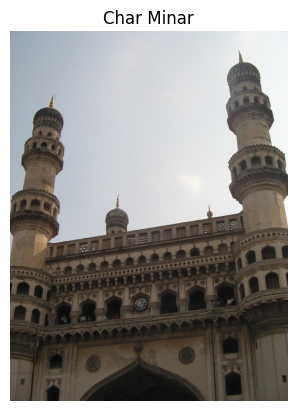

In [ ]:
predict_image("/content/testimg4.jpg",model_clf)

In [ ]:
# save the model
model_clf.save("/content/classifier/classifier.h5")

In [ ]:
test_model = keras.models.load_model("/content/classifier/classifier.h5")

1/1 [==============================] - 0s 58ms/step


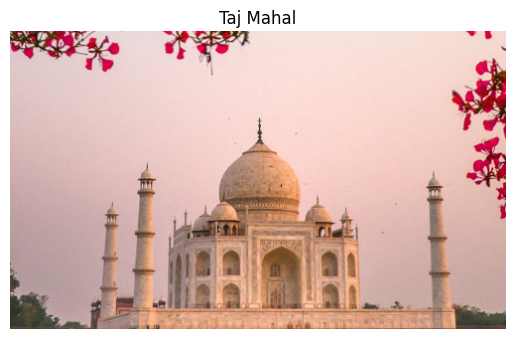

In [ ]:
predict_image("/content/testimg6.jpg",test_model)